# Table of Contents<a id="Top"></a>

1. [Problem Statement](#1)<br>
2. [Data](#2) <br>
3. [Model Definition](#3)<br>
4. [Model Solution](#4)<br>
5. [Sensitivity Analysis](#5)<br>
    5.1 [TUC - ATL](#5.1)<br>

# 1. Problem Statement<a id=1></a>

This problem is one of our first network problem examples from Example 3.1 in the textbook. Recall that the problem is related to shipping from plants to warehouses with the follong capacity and requirement constraints. Our goal is to minimize the costs. 

If you have the figure `problem.png` in the same folder as this .ipynb, you can see the picture that uses this code: `![Table of Data](problem.png)`

![Table of Data](problem.png)

##### [Back to Top](#Top)

# 2. Data<a id=2></a>

In [2]:
import pandas as pd 
import pyomo.environ as pe
import matplotlib.pyplot as plt
import seaborn as sns

### Read and convert data

The first sheet in the excel file `w05-c02-transportation.xlsx` contains the problem setup and solution to this linear program. There are also 2 additional sheets: `coef` and `rhs` that hold the data needed to create the objective function and constraints. The `index_col=0` tells it to use the first row (remember the first row is index 0) as column headers. The `usecols` tells it what columns to import. Remember the first column index is 0. Use tab in the pd.read_excel() function see the different options. Note that we will use the `pd.ExcelFile` to read in the file and then extract sheets individually in the code cell after reading the Excel file.

In [3]:
xlsx_file = pd.ExcelFile('w06-c01-transportation.xlsx')
xlsx_file.sheet_names

['Sensitivity Report 1', 'Transportation', 'coef', 'rhs']

Show the tab and shift-tab tricks. 

In [4]:
cost = pd.read_excel(xlsx_file, sheet_name = 'coef', index_col = 0)
cost

,ATL,BOS,CHI,DEN
MIN,0.60,0.56,0.22,0.40
PIT,0.36,0.30,0.28,0.58
TUC,0.65,0.68,0.55,0.42


In [5]:
demand = pd.read_excel(xlsx_file, sheet_name = 'rhs', index_col = 0, usecols = [0,1])
capacity = pd.read_excel(xlsx_file, sheet_name = 'rhs', index_col = 0, 
                         usecols = [3,4], nrows = 3)

In [6]:
demand

,Requirement
Warehouse,
ATL,8000
BOS,10000
CHI,12000
DEN,9000


In [7]:
capacity

,Capacity
Plant,
MIN,10000
PIT,15000
TUC,15000


##### [Back to Top](#Top)

# 3. Model Definition<a id=3><a>

In [8]:
model = pe.ConcreteModel()

### Define Decision Variables

We will create three plant variables with individual indexes for the four warehouses. 

In [9]:
DV_indexes = ['ATL', 'BOS', 'CHI', 'DEN']
model.MIN = pe.Var(DV_indexes, domain = pe.NonNegativeReals)
model.PIT = pe.Var(DV_indexes, domain = pe.NonNegativeReals)
model.TUC = pe.Var(DV_indexes, domain = pe.NonNegativeReals)
model.pprint()

3 Set Declarations
    MIN_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    4 : {'ATL', 'BOS', 'CHI', 'DEN'}
    PIT_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    4 : {'ATL', 'BOS', 'CHI', 'DEN'}
    TUC_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    4 : {'ATL', 'BOS', 'CHI', 'DEN'}

3 Var Declarations
    MIN : Size=4, Index=MIN_index
        Key : Lower : Value : Upper : Fixed : Stale : Domain
        ATL :     0 :  None :  None : False :  True : NonNegativeReals
        BOS :     0 :  None :  None : False :  True : NonNegativeReals
        CHI :     0 :  None :  None : False :  True : NonNegativeReals
        DEN :     0 :  None :  None : False :  True : NonNegativeReals
    PIT : Size=4, Index=PIT_index
        Key : Lower : Value : Upper : Fix

### Define Objective Function

Here we need to create a formula for all 12 decision variables. We loop through the warehouse indexes for each plant.

In [10]:
model.obj = pe.Objective(expr = sum([cost.loc['MIN', index]*model.MIN[index] for index in DV_indexes] +
                         [cost.loc['PIT', index]*model.PIT[index] for index in DV_indexes] +
                         [cost.loc['TUC', index]*model.TUC[index] for index in DV_indexes]),
                         sense = pe.minimize)

In [11]:
model.obj.pprint()

obj : Size=1, Index=None, Active=True
    Key  : Active : Sense    : Expression
    None :   True : minimize : 0.6*MIN[ATL] + 0.56*MIN[BOS] + 0.22*MIN[CHI] + 0.4*MIN[DEN] + 0.36*PIT[ATL] + 0.3*PIT[BOS] + 0.28*PIT[CHI] + 0.58*PIT[DEN] + 0.65*TUC[ATL] + 0.68*TUC[BOS] + 0.55*TUC[CHI] + 0.42*TUC[DEN]


### Define Constraints

We finish defining the model by defining both the capacity and demand constraints.

In [12]:
capacity.loc['PIT', 'Capacity']

15000

In [13]:
#Capacity Constraints
model.con_MIN = pe.Constraint(expr = sum([model.MIN[index] for index in DV_indexes]) 
                              <= capacity.loc['MIN','Capacity'])
model.con_PIT = pe.Constraint(expr = sum([model.PIT[index] for index in DV_indexes])
                              <= capacity.loc['PIT','Capacity'])
model.con_TUC = pe.Constraint(expr = sum([model.TUC[index] for index in DV_indexes])
                              <= capacity.loc['TUC','Capacity'])   
#Demand Constraints
model.con_ATL = pe.Constraint(expr = model.MIN['ATL'] + model.PIT['ATL']+ 
                              model.TUC['ATL'] >= demand.loc['ATL', 'Requirement'])
model.con_BOS = pe.Constraint(expr = model.MIN['BOS'] + model.PIT['BOS']+ 
                              model.TUC['BOS'] >= demand.loc['BOS', 'Requirement'])
model.con_CHI = pe.Constraint(expr = model.MIN['CHI'] + model.PIT['CHI']+ 
                              model.TUC['CHI'] >= demand.loc['CHI', 'Requirement'])
model.con_DEN = pe.Constraint(expr = model.MIN['DEN'] + model.PIT['DEN']+ 
                              model.TUC['DEN'] >= demand.loc['DEN', 'Requirement'])

In [14]:
model.con_MIN.pprint()

con_MIN : Size=1, Index=None, Active=True
    Key  : Lower : Body                                      : Upper   : Active
    None :  -Inf : MIN[ATL] + MIN[BOS] + MIN[CHI] + MIN[DEN] : 10000.0 :   True


##### [Back to Top](#Top)

# 4. Model Solution<a id=4></a>

In [15]:
opt = pe.SolverFactory('glpk')
result = opt.solve(model, tee = False)
print(result.solver.status, result.solver.termination_condition)

ok optimal


And here we show the final values for the model shown in the constraints as `Body`.
Note we can see the final values for our demand and capacity constraints. All of our lhs values are at the bounds so are binding constraints except for capacity constraint 3 which had a final value of 14,000 but the capacity is 15,000 so it had a slack of 1,000 units.

In [16]:
model.display()

Model unknown

  Variables:
    MIN : Size=4, Index=MIN_index
        Key : Lower : Value   : Upper : Fixed : Stale : Domain
        ATL :     0 :     0.0 :  None : False : False : NonNegativeReals
        BOS :     0 :     0.0 :  None : False : False : NonNegativeReals
        CHI :     0 : 10000.0 :  None : False : False : NonNegativeReals
        DEN :     0 :     0.0 :  None : False : False : NonNegativeReals
    PIT : Size=4, Index=PIT_index
        Key : Lower : Value   : Upper : Fixed : Stale : Domain
        ATL :     0 :  5000.0 :  None : False : False : NonNegativeReals
        BOS :     0 : 10000.0 :  None : False : False : NonNegativeReals
        CHI :     0 :     0.0 :  None : False : False : NonNegativeReals
        DEN :     0 :     0.0 :  None : False : False : NonNegativeReals
    TUC : Size=4, Index=TUC_index
        Key : Lower : Value  : Upper : Fixed : Stale : Domain
        ATL :     0 : 3000.0 :  None : False : False : NonNegativeReals
        BOS :     0 :    0

The above shows us all the information all at once. Let's pull out the optimal minimum cost and the final value of the decision variables.

#### Optimal Objective Value

In [17]:
obj_val = model.obj.expr()
print(f'optimal objective value minimum cost = ${obj_val:.2f}')

optimal objective value minimum cost = $13830.00


#### Optimal Decision Variables

In order to capture the results, we have to use new code to reference the 3 variable names - `model.component_objects(pe.Var)` and each set of indexes. We can use looping to pull out the values. 

In [18]:
for DV in model.component_objects(pe.Var):
    print(DV)
    for var in DV:
        print(" ", var, DV[var].value)

MIN
  ATL 0.0
  BOS 0.0
  CHI 10000.0
  DEN 0.0
PIT
  ATL 5000.0
  BOS 10000.0
  CHI 0.0
  DEN 0.0
TUC
  ATL 3000.0
  BOS 0.0
  CHI 2000.0
  DEN 9000.0


Let's do create a `pd.DataFrame` to store the results of our solution. 

In [19]:
DV_solution = pd.DataFrame()
for DV in model.component_objects(pe.Var):
    for var in DV:
        DV_solution.loc[DV.name, var] = DV[var].value
DV_solution

,ATL,BOS,CHI,DEN
MIN,0.0,0.0,10000.0,0.0
PIT,5000.0,10000.0,0.0,0.0
TUC,3000.0,0.0,2000.0,9000.0


# 5. Sensitivity Analysis<a id=5></a>

In this section, we are going to have to write a bit of code to do a little more advanced sensitivity analysis. Make sure you can follow the model set up up above for sure for now, and then see what you can follow below.

In the original problem, one of the highest costs is for Tucson to Atlanta and Tuscon to Boston at .65 and .68. Let's try to manually change the cost for these paths (represented by `cost.loc['TUC','ATL']` and `cost.loc['TUC','BOS']` below) to a range of values between .55 amd .68. Once we update the cost, we just re-solve the model and save the results to the following lists: `DV_list_ta` holds the Decision Variables, `obj_list_ta` holds the objective function values.

But first, let's make things easy on ourselves and create a function to run the model. We'll call it `run_model`. FYI, don't make functions until you are sure that all the code works outside of the function!

In [20]:
def run_model():
    #Function to run the model 
    
    #This just runs the model as we defined it above
    model = pe.ConcreteModel()
    #Decision Variables
    DV_indexes = ['ATL', 'BOS', 'CHI', 'DEN']
    model.MIN = pe.Var(DV_indexes, domain = pe.NonNegativeReals)
    model.PIT = pe.Var(DV_indexes, domain = pe.NonNegativeReals)
    model.TUC = pe.Var(DV_indexes, domain = pe.NonNegativeReals)
    #Objective Function
    model.obj = pe.Objective(expr = sum([cost.loc['MIN', index]*model.MIN[index] for index in DV_indexes] +
                             [cost.loc['PIT', index]*model.PIT[index] for index in DV_indexes] +
                             [cost.loc['TUC', index]*model.TUC[index] for index in DV_indexes]),
                             sense = pe.minimize)
    #Capacity Constraints
    model.con_MIN = pe.Constraint(expr = sum(model.MIN[index] for index in DV_indexes) 
                                  <= capacity.loc['MIN','Capacity'])
    model.con_PIT = pe.Constraint(expr = sum(model.PIT[index] for index in DV_indexes)
                                  <= capacity.loc['PIT','Capacity'])
    model.con_TUC = pe.Constraint(expr = sum(model.TUC[index] for index in DV_indexes)
                                  <= capacity.loc['TUC','Capacity'])   
    #Demand Constraints
    model.con_ATL = pe.Constraint(expr = model.MIN['ATL'] + model.PIT['ATL']+ 
                                  model.TUC['ATL'] >= demand.loc['ATL','Requirement'])
    model.con_BOS = pe.Constraint(expr = model.MIN['BOS'] + model.PIT['BOS']+ 
                                  model.TUC['BOS'] >= demand.loc['BOS','Requirement'])
    model.con_CHI = pe.Constraint(expr = model.MIN['CHI'] + model.PIT['CHI']+ 
                                  model.TUC['CHI'] >= demand.loc['CHI','Requirement'])
    model.con_DEN = pe.Constraint(expr = model.MIN['DEN'] + model.PIT['DEN']+ 
                                  model.TUC['DEN'] >= demand.loc['DEN','Requirement'])
    opt = pe.SolverFactory('glpk')
    opt.solve(model, tee=False) #solve model and supress output
    
    #Once we solve the model we return the model object so we can get the optimal obj function value
    return model

## Minneapolis Constraint<a id=5.1></a>

Here is the original capacity table. We are going to vary the MIN capacity and see what happens to our objective function.

In [21]:
capacity

,Capacity
Plant,
MIN,10000
PIT,15000
TUC,15000


In [41]:
new_cap = [i*100 for i in list(range(90, 130))]
new_cap

[9000,
 9100,
 9200,
 9300,
 9400,
 9500,
 9600,
 9700,
 9800,
 9900,
 10000,
 10100,
 10200,
 10300,
 10400,
 10500,
 10600,
 10700,
 10800,
 10900,
 11000,
 11100,
 11200,
 11300,
 11400,
 11500,
 11600,
 11700,
 11800,
 11900,
 12000,
 12100,
 12200,
 12300,
 12400,
 12500,
 12600,
 12700,
 12800,
 12900]

In [42]:
obj_list = []
for val in new_cap:
    capacity.loc['MIN'] = val
    model = run_model()
    obj_list.append(model.obj.expr())
obj_list

[14160.0,
 14127.0,
 14094.0,
 14061.0,
 14028.0,
 13995.0,
 13962.0,
 13929.0,
 13896.0,
 13863.0,
 13830.0,
 13797.0,
 13764.0,
 13731.0,
 13698.0,
 13665.0,
 13632.0,
 13599.0,
 13566.0,
 13533.0,
 13500.0,
 13467.0,
 13434.0,
 13401.0,
 13368.0,
 13335.0,
 13302.0,
 13269.0,
 13236.0,
 13203.0,
 13170.0,
 13165.0,
 13160.0,
 13155.0,
 13150.0,
 13145.0,
 13140.0,
 13135.0,
 13130.0,
 13125.0]

Let's make the same plot using `seaborn` rather than base `pandas` plot. First, I'm going to show a new function for "merging" two (or more) lists, the zip function.

In [24]:
zip_list = list(zip(new_cap, obj_list))
zip_list

[(9000, 14160.0),
 (9100, 14127.0),
 (9200, 14094.0),
 (9300, 14061.0),
 (9400, 14028.0),
 (9500, 13995.0),
 (9600, 13962.0),
 (9700, 13929.0),
 (9800, 13896.0),
 (9900, 13863.0),
 (10000, 13830.0),
 (10100, 13797.0),
 (10200, 13764.0),
 (10300, 13731.0),
 (10400, 13698.0),
 (10500, 13665.0),
 (10600, 13632.0),
 (10700, 13599.0),
 (10800, 13566.0),
 (10900, 13533.0),
 (11000, 13500.0),
 (11100, 13467.0),
 (11200, 13434.0),
 (11300, 13401.0),
 (11400, 13368.0),
 (11500, 13335.0),
 (11600, 13302.0),
 (11700, 13269.0),
 (11800, 13236.0),
 (11900, 13203.0),
 (12000, 13170.0),
 (12100, 13165.0),
 (12200, 13160.0),
 (12300, 13155.0),
 (12400, 13150.0),
 (12500, 13145.0),
 (12600, 13140.0),
 (12700, 13135.0),
 (12800, 13130.0),
 (12900, 13125.0)]

In [25]:
df = pd.DataFrame(zip_list, columns = ['MIN_CAP', 'Cost'])
df

,MIN_CAP,Cost
0,9000,14160.0
1,9100,14127.0
2,9200,14094.0
3,9300,14061.0
4,9400,14028.0
5,9500,13995.0
6,9600,13962.0
7,9700,13929.0
8,9800,13896.0
9,9900,13863.0


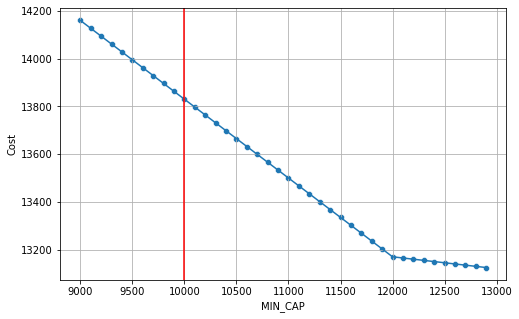

In [26]:
plt.figure(figsize = (8,5))
sns.scatterplot(x = 'MIN_CAP', y = 'Cost', data = df)
sns.lineplot(x = 'MIN_CAP', y = 'Cost', data = df)
plt.grid()
plt.axvline(x = 10000, color = "red")
plt.show()

In [45]:
l1 = ["M", "P", "T"]
l2 = ["A", "B", "C", "D"]
l3 = []
for i in l1:
    for x in l2:
        l3.append(f"{i}-{x}")

l3


['M-A',
 'M-B',
 'M-C',
 'M-D',
 'P-A',
 'P-B',
 'P-C',
 'P-D',
 'T-A',
 'T-B',
 'T-C',
 'T-D']

In [44]:
DV_list = []
for val in new_cap:
    DV_curr_list = []
    capacity.loc['MIN'] = val
    model = run_model()
    for DV in model.component_objects(pe.Var): #each origin
        for c in DV: #each destination
            DV_curr_list.append(DV[c].value)
    DV_list.append(DV_curr_list)
print(*DV_list, sep="\n")

[0.0, 0.0, 9000.0, 0.0, 5000.0, 10000.0, 0.0, 0.0, 3000.0, 0.0, 3000.0, 9000.0]
[0.0, 0.0, 9100.0, 0.0, 5000.0, 10000.0, 0.0, 0.0, 3000.0, 0.0, 2900.0, 9000.0]
[0.0, 0.0, 9200.0, 0.0, 5000.0, 10000.0, 0.0, 0.0, 3000.0, 0.0, 2800.0, 9000.0]
[0.0, 0.0, 9300.0, 0.0, 5000.0, 10000.0, 0.0, 0.0, 3000.0, 0.0, 2700.0, 9000.0]
[0.0, 0.0, 9400.0, 0.0, 5000.0, 10000.0, 0.0, 0.0, 3000.0, 0.0, 2600.0, 9000.0]
[0.0, 0.0, 9500.0, 0.0, 5000.0, 10000.0, 0.0, 0.0, 3000.0, 0.0, 2500.0, 9000.0]
[0.0, 0.0, 9600.0, 0.0, 5000.0, 10000.0, 0.0, 0.0, 3000.0, 0.0, 2400.0, 9000.0]
[0.0, 0.0, 9700.0, 0.0, 5000.0, 10000.0, 0.0, 0.0, 3000.0, 0.0, 2300.0, 9000.0]
[0.0, 0.0, 9800.0, 0.0, 5000.0, 10000.0, 0.0, 0.0, 3000.0, 0.0, 2200.0, 9000.0]
[0.0, 0.0, 9900.0, 0.0, 5000.0, 10000.0, 0.0, 0.0, 3000.0, 0.0, 2100.0, 9000.0]
[0.0, 0.0, 10000.0, 0.0, 5000.0, 10000.0, 0.0, 0.0, 3000.0, 0.0, 2000.0, 9000.0]
[0.0, 0.0, 10100.0, 0.0, 5000.0, 10000.0, 0.0, 0.0, 3000.0, 0.0, 1900.0, 9000.0]
[0.0, 0.0, 10200.0, 0.0, 5000.0, 10000

Again, let's format this so it is easy to read.

In [28]:
DV_col_names = ['M-A', 'M-B', 'M-C', 'M-D', 'P-A', 'P-B', 'P-C', 'P-D', 'T-A', 'T-B', 'T-C', 'T-D']
DV_df = pd.DataFrame(DV_list,
                      columns = DV_col_names)
DV_df['Capacity'] = new_cap
DV_df

,M-A,M-B,M-C,M-D,P-A,P-B,P-C,P-D,T-A,T-B,T-C,T-D,Capacity
0,0.0,0.0,9000.0,0.0,5000.0,10000.0,0.0,0.0,3000.0,0.0,3000.0,9000.0,9000
1,0.0,0.0,9100.0,0.0,5000.0,10000.0,0.0,0.0,3000.0,0.0,2900.0,9000.0,9100
2,0.0,0.0,9200.0,0.0,5000.0,10000.0,0.0,0.0,3000.0,0.0,2800.0,9000.0,9200
3,0.0,0.0,9300.0,0.0,5000.0,10000.0,0.0,0.0,3000.0,0.0,2700.0,9000.0,9300
4,0.0,0.0,9400.0,0.0,5000.0,10000.0,0.0,0.0,3000.0,0.0,2600.0,9000.0,9400
5,0.0,0.0,9500.0,0.0,5000.0,10000.0,0.0,0.0,3000.0,0.0,2500.0,9000.0,9500
6,0.0,0.0,9600.0,0.0,5000.0,10000.0,0.0,0.0,3000.0,0.0,2400.0,9000.0,9600
7,0.0,0.0,9700.0,0.0,5000.0,10000.0,0.0,0.0,3000.0,0.0,2300.0,9000.0,9700
8,0.0,0.0,9800.0,0.0,5000.0,10000.0,0.0,0.0,3000.0,0.0,2200.0,9000.0,9800
9,0.0,0.0,9900.0,0.0,5000.0,10000.0,0.0,0.0,3000.0,0.0,2100.0,9000.0,9900


We'll finish looking at this data by creating a line plot to monitor the changes in the optimal DV over the different Tucson-Atlanta cost changes. So - this kinda works but we have too
many decision variables it is hard to follow the colors.

In [29]:
df = pd.melt(DV_df, 'Capacity')
df

,Capacity,variable,value
0,9000,M-A,0.0
1,9100,M-A,0.0
2,9200,M-A,0.0
3,9300,M-A,0.0
4,9400,M-A,0.0
...,...,...,...
475,12500,T-D,9000.0
476,12600,T-D,9000.0
477,12700,T-D,9000.0
478,12800,T-D,9000.0


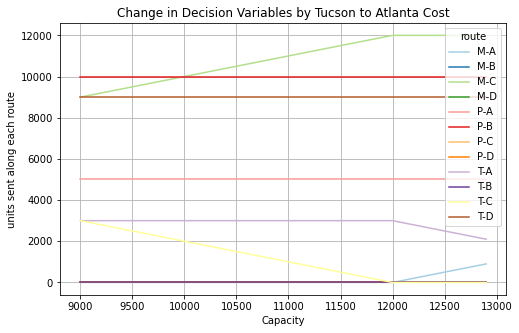

In [30]:
plt.figure(figsize=(8, 5))
sns.lineplot(x = 'Capacity', y = 'value', hue = 'variable', palette = sns.color_palette("Paired"),
             data = df)
plt.grid()
plt.title('Change in Decision Variables by Tucson to Atlanta Cost')
plt.ylabel('units sent along each route')
plt.legend(title = "route")
plt.show()

For our final version, let's create a plot for each Plant's Decision Variables. Remember we stored the (Plant, Warehouse) pairs for the Decision Variables in the list `DV_col_names`. I will pull out just the ones that are needed for the specific Plant. For example, here we see the Tucson pairs.

In [31]:
df['plants'] = df['variable'].str[:1]
df

,Capacity,variable,value,plants
0,9000,M-A,0.0,M
1,9100,M-A,0.0,M
2,9200,M-A,0.0,M
3,9300,M-A,0.0,M
4,9400,M-A,0.0,M
...,...,...,...,...
475,12500,T-D,9000.0,T
476,12600,T-D,9000.0,T
477,12700,T-D,9000.0,T
478,12800,T-D,9000.0,T


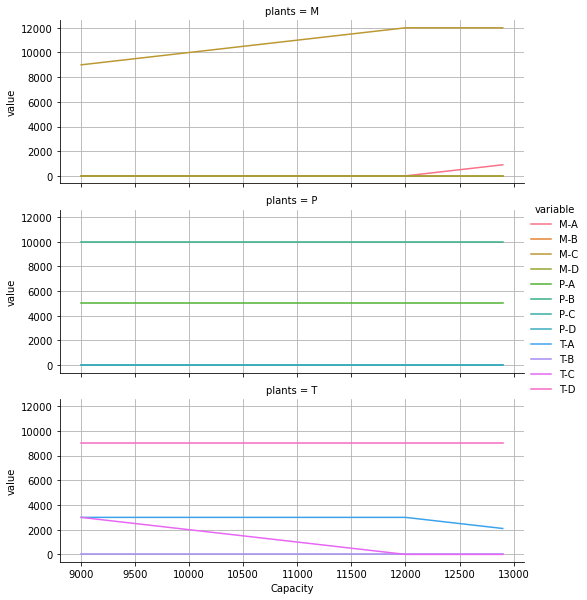

In [48]:
sns.set_style({'axes.grid' : True, 'axes.edgecolor' : 'black'})
facet_plot = sns.FacetGrid(data = df, row = 'plants', hue = 'variable', height = 3, aspect = 2.5)
facet_plot.map(sns.lineplot, 'Capacity', 'value').add_legend()
facet_plot.fig.subplots_adjust(top = 0.9)
# facet_plot.fig.suptitle('Change in Decision Variables by Change in MIN Capacity')
plt.show()